In [1]:
# 10_inference.ipynb

# ==============================================================================
# 1. 라이브러리 및 설정
# ==============================================================================
import os
import pandas as pd
import torch
from PIL import Image
import numpy as np
import mlflow
from transformers import ViTImageProcessor, AutoModelForImageClassification

# 백본 모델 클래스 순서
backbone_classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

/workspace/miniconda3/envs/mlflow_env/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
# ==============================================================================
# 2. 모델 로드
# ==============================================================================

# MLflow run_id를 지정합니다. (08_finetuning.py 실행 후 MLflow UI에서 확인)
# 아래 코드에서 run_id를 적절히 수정해 주세요.

# run_id = "c88cb1374eed41dc9d164a91a5f4e956" 

# MLflow에서 파인튜닝된 모델 로드
# try:
#     model_uri = f"runs:/{run_id}/emotion_fine_tuned_model"
#     model = mlflow.pytorch.load_model(model_uri)
#     print(f"MLflow에서 run_id: {run_id}의 모델을 성공적으로 로드했습니다.")

try:
    # 모델 로드 방식을 로컬 파일 시스템 경로로 변경하여 더 안정적으로 로드합니다.
    # 이 경로는 스크립트 실행 위치에 따라 달라질 수 있으므로, 경로를 정확하게 확인해야 합니다.
    local_model_path = "/workspace/AI/mlruns/1/models/m-910a9ab6c6774d73b669a0baefe1fd11/artifacts/"
    model = mlflow.pytorch.load_model(local_model_path)
    print(f"MLflow에서 run_id: {run_id}의 모델을 성공적으로 로드했습니다.")

except Exception as e:
    print(f"모델 로드 실패: {e}")
    # 예외 발생 시, 로컬에서 백본 모델을 로드하는 대체 코드
    model_name = "HardlyHumans/Facial-expression-detection"
    model = AutoModelForImageClassification.from_pretrained(model_name)
    print("모델 로드에 실패하여 로컬에서 백본 모델을 로드했습니다.")
    
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = ViTImageProcessor.from_pretrained("HardlyHumans/Facial-expression-detection", use_fast=True)

MLflow에서 run_id: c88cb1374eed41dc9d164a91a5f4e956의 모델을 성공적으로 로드했습니다.


In [11]:
from PIL import Image, ExifTags

def correct_image_orientation(img):
    try:
        exif = img._getexif()
        if exif is not None:
            for tag, value in exif.items():
                if ExifTags.TAGS.get(tag, None) == 'Orientation':
                    if value == 1: pass
                    elif value == 2: img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    elif value == 3: img = img.rotate(180, expand=True)
                    elif value == 4: img = img.transpose(Image.FLIP_TOP_BOTTOM)
                    elif value == 5: img = img.transpose(Image.FLIP_LEFT_RIGHT).rotate(-90, expand=True)
                    elif value == 6: img = img.rotate(-90, expand=True)
                    elif value == 7: img = img.transpose(Image.FLIP_LEFT_RIGHT).rotate(90, expand=True)
                    elif value == 8: img = img.rotate(90, expand=True)
    except Exception: pass
    return img

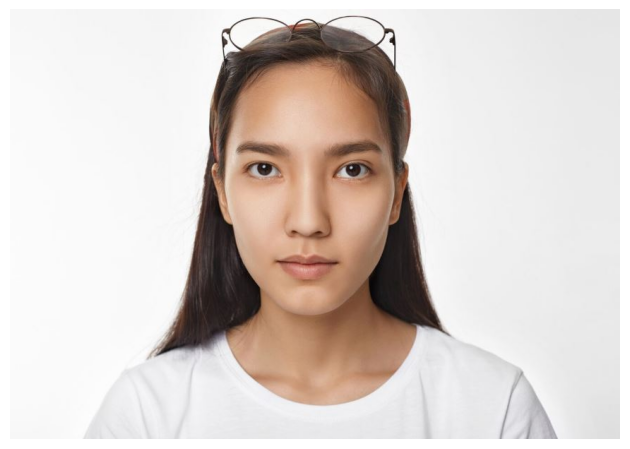


==== 감정 분류 결과 ====
[neutral]: 0.7489
[happy]: 0.1848
[sad]: 0.0198
[fear]: 0.0166
[contempt]: 0.0117
[anger]: 0.0095
[surprise]: 0.0062
[disgust]: 0.0026


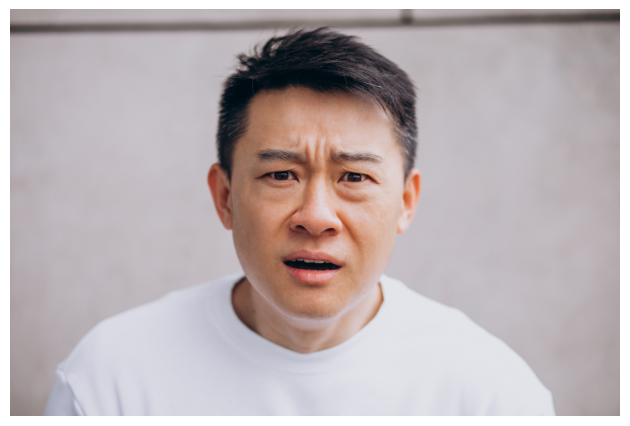


==== 감정 분류 결과 ====
[fear]: 0.4135
[surprise]: 0.2823
[sad]: 0.1233
[anger]: 0.0883
[contempt]: 0.0472
[disgust]: 0.0186
[neutral]: 0.0175
[happy]: 0.0093


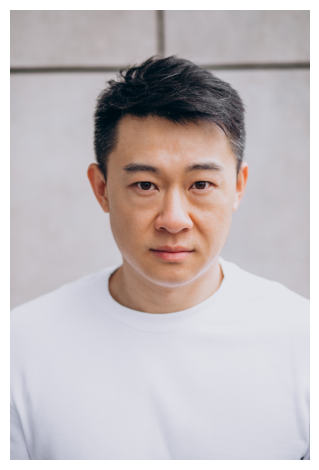


==== 감정 분류 결과 ====
[happy]: 0.5984
[contempt]: 0.1205
[neutral]: 0.1098
[anger]: 0.0971
[disgust]: 0.0288
[sad]: 0.0241
[fear]: 0.0197
[surprise]: 0.0016


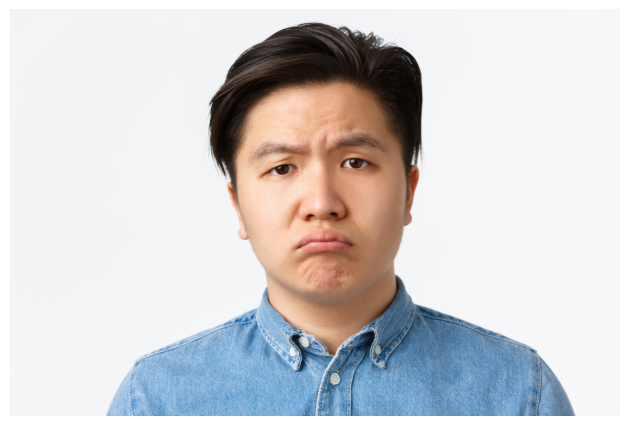


==== 감정 분류 결과 ====
[sad]: 0.5539
[fear]: 0.1762
[anger]: 0.1340
[contempt]: 0.0665
[disgust]: 0.0486
[neutral]: 0.0130
[surprise]: 0.0076
[happy]: 0.0002


In [16]:
import matplotlib.pyplot as plt

# ==============================================================================
# 3. 특정 이미지에 대한 감정 분류
# ==============================================================================

import glob

directory   = "./FER/Data/Google_search/"
image_paths = glob.glob(f"{directory}*.jpg")    # 하위 폴더 제외, .jpg 파일만

for image_path in image_paths:
    # 이미지 로드 및 전처리
    try:
        image = Image.open(image_path)
        image = correct_image_orientation(image)
        image = image.convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        inputs = processor(images=image, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # 추론 수행
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            # Softmax를 적용하여 확률 분포로 변환
            probabilities = torch.softmax(logits, dim=1).squeeze().cpu().numpy()

        # 결과 출력
        print("\n==== 감정 분류 결과 ====")
        # 확률을 내림차순으로 정렬
        sorted_indices = np.argsort(probabilities)[::-1]
        
        for i in sorted_indices:
            emotion = backbone_classes[i]
            probability = probabilities[i]
            print(f"[{emotion}]: {probability:.4f}")

    except FileNotFoundError:
        print(f"오류: '{image_path}' 파일을 찾을 수 없습니다. 경로를 확인해 주세요.")
    except Exception as e:
        print(f"오류 발생: {e}")

